In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
data = pd.read_csv('Google_train_data.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


Now let us preprocess the data to transform our closing price variable to a numeric type variable

In [4]:
data["Close"] = pd.to_numeric(data.Close,errors='coerce')
data = data.dropna()
trainData = data.iloc[:,4:5].values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1149 non-null   object 
 1   Open    1149 non-null   float64
 2   High    1149 non-null   float64
 3   Low     1149 non-null   float64
 4   Close   1149 non-null   float64
 5   Volume  1149 non-null   object 
dtypes: float64(4), object(2)
memory usage: 62.8+ KB


You can now observe that the datatype of 'Close' column has changed to 'float' data type

Now we'll rescale our data into values between 0 and 1 for better performances

In [6]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(1149, 1)

In [7]:
X_train = []
y_train = []

for i in range (60,1149): #60 : timesteps , 1149: Length of the data
    X_train.append(trainData[i-60:i,0])
    y_train.append(trainData[i,0])
    
X_train, y_train = np.array(X_train),np.array(y_train)

We'll be adding another axis for the batch size since the input for a LSTM network is a 3D tensor so it will have a sequence length, the timesteps, and batch size. 

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))   # adding the batch size axis
X_train.shape

(1089, 60, 1)

Now we'll build a model containing 4 layers of LSTM network. All followed by a dropout layer. On the top we will also have a final dense layer. All of this is compiled using an Adam optimizer and mean squared error as a loss function.

In [17]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [18]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2)

Epoch 1/20
35/35 - 13s - loss: 0.0346 - 13s/epoch - 375ms/step
Epoch 2/20
35/35 - 7s - loss: 0.0116 - 7s/epoch - 188ms/step
Epoch 3/20
35/35 - 8s - loss: 0.0109 - 8s/epoch - 227ms/step
Epoch 4/20
35/35 - 6s - loss: 0.0107 - 6s/epoch - 169ms/step
Epoch 5/20
35/35 - 9s - loss: 0.0130 - 9s/epoch - 271ms/step
Epoch 6/20
35/35 - 6s - loss: 0.0068 - 6s/epoch - 175ms/step
Epoch 7/20
35/35 - 6s - loss: 0.0065 - 6s/epoch - 172ms/step
Epoch 8/20
35/35 - 8s - loss: 0.0090 - 8s/epoch - 242ms/step
Epoch 9/20
35/35 - 9s - loss: 0.0078 - 9s/epoch - 244ms/step
Epoch 10/20
35/35 - 8s - loss: 0.0059 - 8s/epoch - 215ms/step
Epoch 11/20
35/35 - 7s - loss: 0.0056 - 7s/epoch - 188ms/step
Epoch 12/20
35/35 - 6s - loss: 0.0055 - 6s/epoch - 178ms/step
Epoch 13/20
35/35 - 7s - loss: 0.0054 - 7s/epoch - 204ms/step
Epoch 14/20
35/35 - 7s - loss: 0.0055 - 7s/epoch - 200ms/step
Epoch 15/20
35/35 - 8s - loss: 0.0054 - 8s/epoch - 224ms/step
Epoch 16/20
35/35 - 8s - loss: 0.0050 - 8s/epoch - 218ms/step
Epoch 17/20
35/

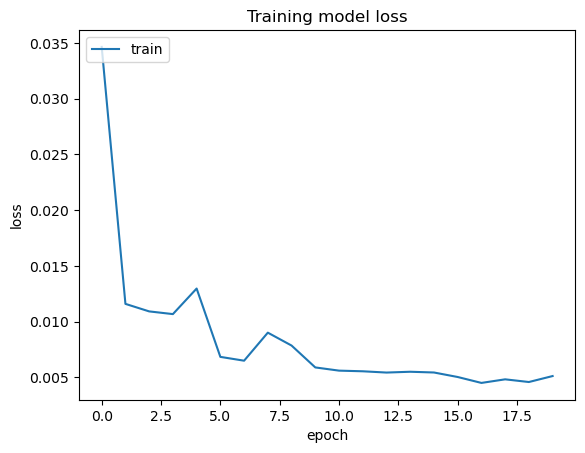

In [19]:
plt.plot(hist.history['loss'])
plt.title("Training model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc="upper left")
plt.show()

In [20]:
testData = pd.read_csv('Google_test_data.csv')
testData["Close"] = pd.to_numeric(testData.Close, errors = 'coerce')
testData = testData.dropna()
testData = testData.iloc[:,4:5]
y_test = testData.iloc[60:,0:].values

#input array for the model
inputClosing = testData.iloc[:,0:].values
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length):
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_test.shape

(192, 60, 1)

In [21]:
y_pred = model.predict(X_test)
y_pred

6/6 [==============================] - 2s 37ms/step


array([[1.2540195],
       [1.2571859],
       [1.2687635],
       [1.286341 ],
       [1.3011335],
       [1.302494 ],
       [1.2901144],
       [1.2716318],
       [1.2586436],
       [1.2542484],
       [1.2474105],
       [1.2364267],
       [1.226193 ],
       [1.2165911],
       [1.2139097],
       [1.2179842],
       [1.235713 ],
       [1.2645613],
       [1.2983284],
       [1.3323054],
       [1.3477299],
       [1.3460202],
       [1.3261255],
       [1.2961022],
       [1.2678932],
       [1.2507402],
       [1.2457392],
       [1.2452147],
       [1.2389405],
       [1.2285864],
       [1.2164385],
       [1.2022822],
       [1.1814182],
       [1.1554937],
       [1.1433058],
       [1.1509187],
       [1.1722991],
       [1.1981089],
       [1.2231946],
       [1.2368883],
       [1.2497308],
       [1.2647982],
       [1.2824321],
       [1.299345 ],
       [1.3113861],
       [1.3139651],
       [1.3050189],
       [1.2959354],
       [1.2928851],
       [1.2983189],


In [22]:
predicted_price = sc.inverse_transform(y_pred)

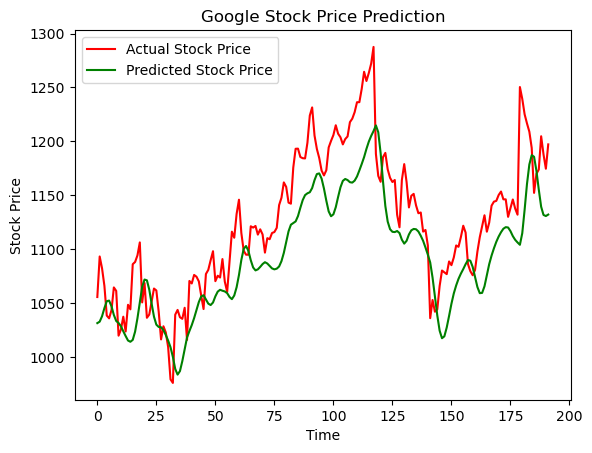

In [23]:
plt.plot(y_test, color='red', label='Actual Stock Price')
plt.plot(predicted_price, color = 'green', label='Predicted Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()